## Load penguin data

In [1]:
import json
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from tqdm import tqdm_notebook

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats import expon
import seaborn as sns
sns.set(color_codes=True)
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
#### function definitions

def amape(y_true, y_pred, accuracies):
    """ Adjusted MAPE
    """
    not_nan_mask = ~np.isnan(y_true)
    
    # calculate absolute error
    abs_error = (np.abs(y_true[not_nan_mask] - y_pred[not_nan_mask]))
    
    # calculate the percent error (replacing 0 with 1
    # in order to avoid divide-by-zero errors).
    pct_error = abs_error / np.maximum(1, y_true[not_nan_mask])
    
    # adjust error by count accuracies
    adj_error = pct_error / accuracies[not_nan_mask]
    
    # return the mean as a percentage
    return np.mean(adj_error)

### 2. Nests counts time series

In [3]:
with open('../data/read_csv_kwargs.json', 'r') as fin:
    kwar = json.load(fin)
    
nests = pd.read_csv('../data/training_set_nest_counts.csv')

ts_nests = pd.read_csv('../data/training_set_nest_counts.csv', **kwar)
en_values = pd.read_csv('../data/training_set_e_n.csv',**kwar)   
sub_format = pd.read_csv('../data/submission_format.csv', **kwar)

ts_nests.columns = ts_nests.columns.astype(int)  
en_values.columns = en_values.columns.astype(int) 
sub_format.columns = sub_format.columns.astype(int) 

#### Split the nest count to try the approach
ts_train = ts_nests[[x for x in ts_nests.columns if x <= 2010]]
ts_target = ts_nests[[x for x in ts_nests.columns if x > 2010]]
en_target = en_values[[x for x in ts_nests.columns if x > 2010]]

ts_pred = ts_target.copy()
ts_pred.ix[:,:] = np.zeros(ts_pred.shape)

names = nests.common_name.unique()
colors = {names[0]:'red', names[1]:'blue', names[2]: 'green'}
print(colors)

{'adelie penguin': 'red', 'gentoo penguin': 'green', 'chinstrap penguin': 'blue'}


In [4]:
pen_sum = nests.groupby('common_name').sum()
pen_sum.columns = pen_sum.columns.astype(int)  

#pen_sum.T.plot(figsize = (18,8),
#               kind = 'bar', stacked = True,                 
#               colors= [colors[x] for x in names],
#               title='Total counts');

#pen_sum.T.plot(figsize = (18,8), 
#               style = '.-',
#               colors= [colors[x] for x in names],
#               title='Total counts per type of penguin');
#plt.xlim(1955, 2014);

pen_nobs = nests.groupby('common_name').count()
del pen_nobs['site_id']

pen_nobs.columns = pen_nobs.columns.astype(int)  
#pen_nobs.T.plot(figsize = (18,8), 
#                style = '.-',  
#                colors= [colors[x] for x in names],
#                title='Number of observations');
#plt.xlim(1955, 2014);

common_name
adelie penguin       17681.059440
chinstrap penguin     4138.399608
gentoo penguin        1326.370368
dtype: float64


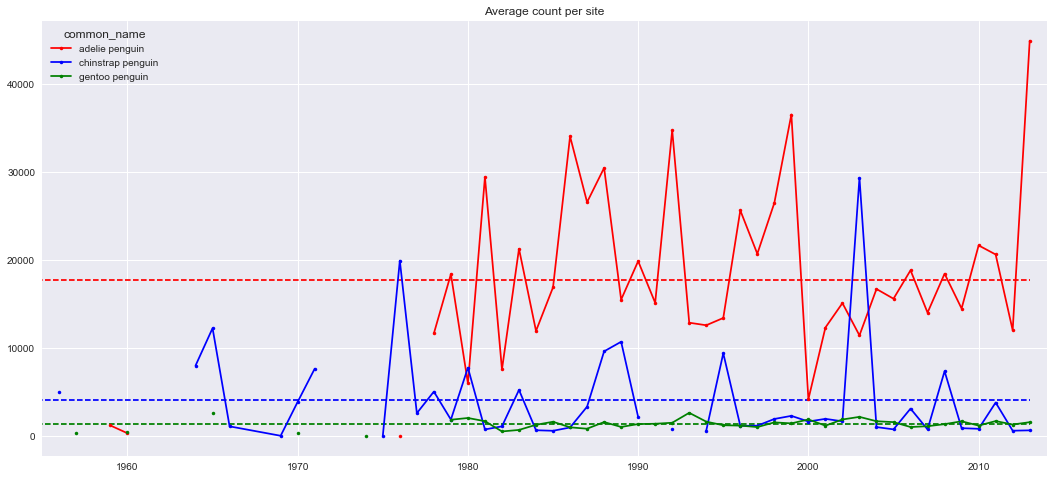

In [5]:
pen_mean = nests.groupby('common_name').mean()
mean_values = pen_mean.mean(axis = 1)
print(mean_values)

pen_mean.columns = pen_mean.columns.astype(int)  

ax = pen_mean.T.plot(figsize = (18,8), 
                     style = '.-', 
                     colors= [colors[x] for x in names],
                     title='Average count per site')

ax.hlines(mean_values, 1895, 2013, 
          color = [colors[x] for x in names], 
          linestyles='--')
plt.xlim(1955, 2014);

The big assumption is that the mean remains constant. This is rather the case for te chinstrap and genboo penguins, but it is questionable for the adelie penguin. 
A moving average could be considered in future improvements?

### 4. Annual rate of change

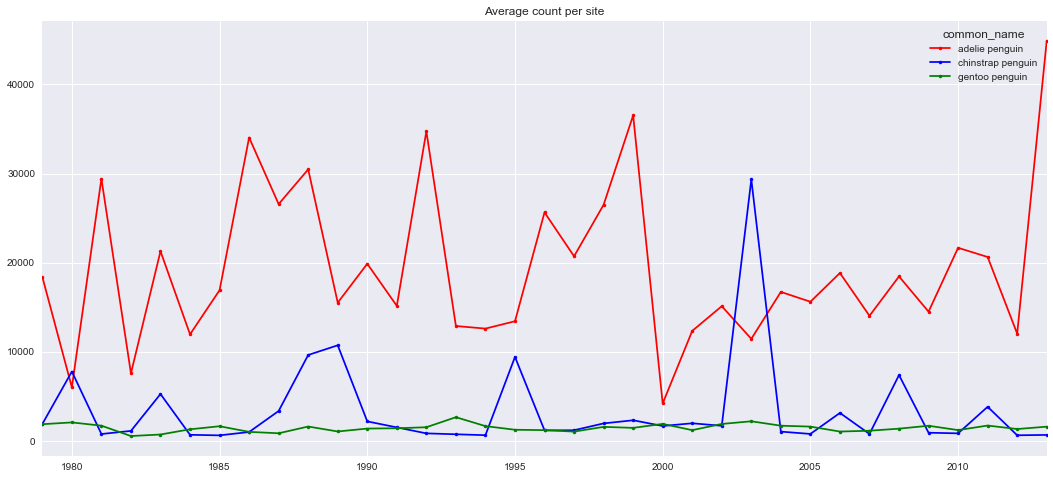

In [6]:
ts = pen_mean.T.ix[1979:].interpolate(method = 'linear')

ts.plot(figsize = (18,8), 
                     style = '.-', 
                     colors= [colors[x] for x in names],
                     title='Average count per site')

In [7]:
ts.describe()

common_name  adelie penguin  chinstrap penguin  gentoo penguin
count             35.000000          35.000000       35.000000
mean           19323.654328        3394.633712     1441.071615
std             9081.729626        5346.162766      426.768077
min             4178.923077         598.000000      522.272727
25%            13143.374384         789.575000     1183.180556
50%            16894.562500        1493.164286     1438.714286
75%            23645.457560        3225.583333     1679.146991
max            44913.066667       29343.600000     2638.000000

In [8]:
mean_values

common_name
adelie penguin       17681.059440
chinstrap penguin     4138.399608
gentoo penguin        1326.370368
dtype: float64

In [9]:
#rates = pd.DataFrame(index = ts.index[:-1], 
#                     columns=ts.columns, 
#                     data =ts.diff()[1:].values/ts[:-1].values)

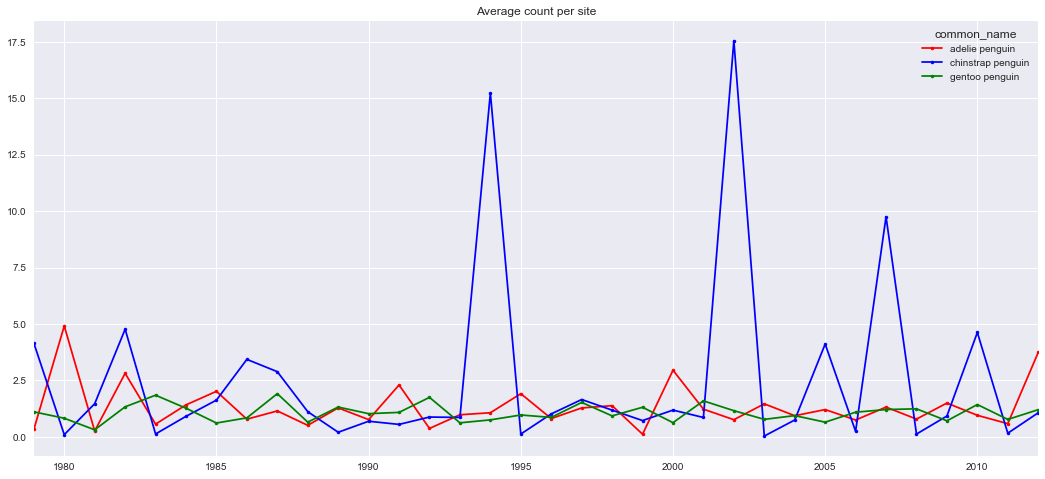

In [10]:
rates = pd.DataFrame(index = ts.index[:-1], 
                     columns=ts.columns, 
                     data =ts[1:].values/ts[:-1].values)

rates.plot(figsize = (18,8), 
                     style = '.-', 
                     colors= [colors[x] for x in names],
                     title='Average count per site')
rates.to_csv('submissions/rates/actual_rates.csv')

## Check forecasts
### 1. Last value

In [11]:
ts_pred_last = ts_pred.copy()
last_value = ts_train.fillna(method='ffill', axis = 1)[2010].fillna(value = 0.0)

for col in ts_pred_last.columns:
    ts_pred_last.ix[:,col] = last_value

last_score = amape(ts_target.values, ts_pred_last.values,en_target.values)
print(last_score)

30.6919213038


### 2. Use actual rates

In [12]:
def evolve_using_rates(trainset, prediction_format, changerate, alpha, minvalue = 0):
    ''' possible tunnable parameters:   smooth factor
                                        minimum value (last valid?, fixed number?)
                                        both could be per penguin type
    '''
    
    firstyearrate = changerate.index[0]    
    prediction = pd.concat([trainset, prediction_format], axis = 1)
    
    for ix in trainset.index:
        penguin = ix[1]
        lastyear = trainset.ix[ix].last_valid_index()
        if lastyear == None:
            pass
        else:
            if lastyear < firstyearrate:
                lastvalue = trainset.ix[ix][lastyear]
                lastyear = firstyearrate

            else:
                lastvalue = trainset.ix[ix][lastyear]
                
            for year in range(lastyear+1, prediction_format.columns[-1]+1):
                rate = changerate.ix[year-1][penguin] 
                #fac = (rate-1)/2*np.tanh((alpha[penguin]-0.5)*6)+(rate-1)/2+1
                fac = 1 + alpha[penguin]*(rate-1)
                lastvalue = np.max([lastvalue*fac, minvalue])
                prediction.ix[ix, year] = lastvalue
            
    return prediction[prediction_format.columns]

In [13]:
smooth = np.linspace(-0.3, 1.3, 30)
scores2 = []
for s in tqdm_notebook(smooth):
    alpha = {names[0]: s,
             names[1]: s,
             names[2]: s}  
    ts_pred_actual_rates = evolve_using_rates(ts_train, ts_pred, rates, alpha)
    #print(amape(ts_target.values, ts_pred_actual_rates.values,en_target.values))
    scores2.append(amape(ts_target.values, ts_pred_actual_rates.values,en_target.values))
    

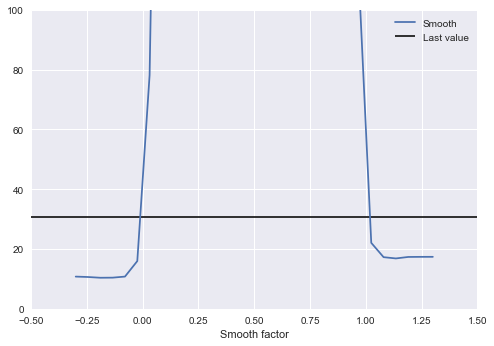

In [14]:
#plt.plot(smooth, scores, label = 'Min = 0')
plt.plot(smooth, scores2, label = 'Smooth')
plt.hlines(last_score, -0.5, 1.5, label = 'Last value')
plt.xlabel('Smooth factor')
plt.axis([-0.5,1.5,0,100])
plt.legend()

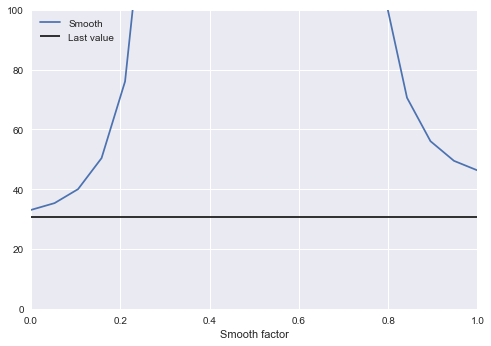

In [30]:
#plt.plot(smooth, scores, label = 'Min = 0')
plt.plot(smooth, scores2, label = 'Smooth')
plt.hlines(last_score, 0, 1, label = 'Last value')
plt.xlabel('Smooth factor')
plt.axis([0,1,0,100])
plt.legend()

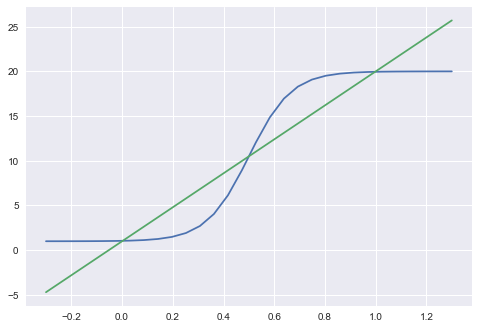

In [44]:
rate = 20
sm = (rate-1)/2*np.tanh((smooth-0.5)*6)+(rate-1)/2+1
sm2 = 1 + smooth*(rate-1)
plt.plot(smooth, sm)
plt.plot(smooth, sm2)

### 3. Estimate rates

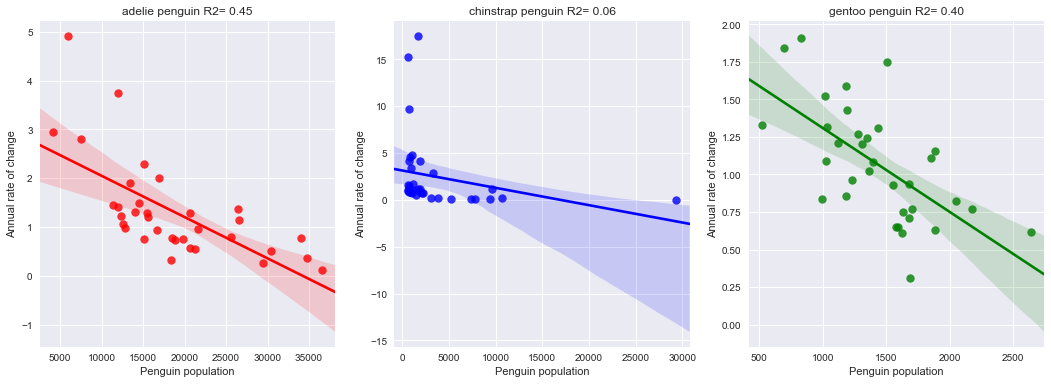

In [12]:
res = dict()
models = dict()

fig, ax = plt.subplots(ncols =3, figsize=(18,6))
for penguin, axi in zip(names, ax):
    x = ts[:-1][penguin].values
    y = rates[penguin].values

    X = sm.add_constant(x[(y>-np.inf) & (x>-np.inf)])
    Y = y[(y>-np.inf) & (x>-np.inf)]   
    
    model = sm.OLS(Y,X)
    models[penguin] = model
    results = model.fit()
    res[penguin] = results
    prstd, iv_l, iv_u = wls_prediction_std(results)

    sns.regplot(ax = axi,
                x = x, 
                y = y,
                scatter_kws = {'s':70, 'color':colors[penguin]},
                color = colors[penguin] )
    
    axi.set_title('{} R2= {:.2f}'.format(penguin, results.rsquared))
    axi.set_xlabel('Penguin population')
    axi.set_ylabel('Annual rate of change')  

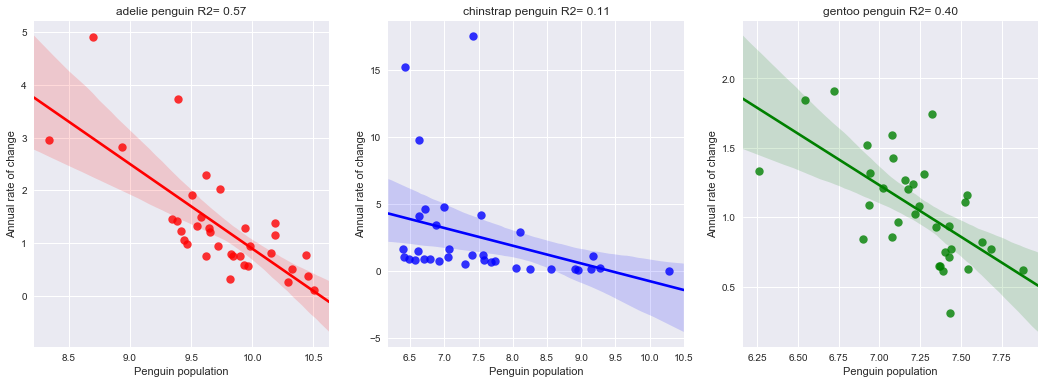

In [13]:
res = dict()
models = dict()

fig, ax = plt.subplots(ncols =3, figsize=(18,6))
for penguin, axi in zip(names, ax):
    x = np.log(ts[:-1][penguin].values)
    y = rates[penguin].values

    X = sm.add_constant(x[(y>-np.inf) & (x>-np.inf)])
    Y = y[(y>-np.inf) & (x>-np.inf)]   
    
    model = sm.OLS(Y,X)
    models[penguin] = model
    results = model.fit()
    res[penguin] = results
    prstd, iv_l, iv_u = wls_prediction_std(results)

    sns.regplot(ax = axi,
                x = x, 
                y = y,
                scatter_kws = {'s':70, 'color':colors[penguin]},
                color = colors[penguin] )
    
    axi.set_title('{} R2= {:.2f}'.format(penguin, results.rsquared))
    axi.set_xlabel('Penguin population')
    axi.set_ylabel('Annual rate of change')  

In [33]:
forecast = pd.DataFrame(index = range(2014, 2018), columns=ts.columns)

for penguin in ts.columns:
    vals = []
    facs = []
    newval = ts.ix[2013][penguin]
    for i in range(4):
        fac = res[penguin].predict(np.array([1,np.log(newval)]))[0]
        newval = np.max((newval*fac, ts[penguin].min()))
        facs.append(fac)
        vals.append(newval)    
    forecast[penguin] = vals
    

In [37]:
(forecast/ts.ix[2013])

common_name  adelie penguin  chinstrap penguin  gentoo penguin
2014               0.093045           3.908550        0.961896
2015               0.331278           8.237620        0.953045
2016               0.504304           9.247600        0.950829
2017               0.427577           8.968417        0.950265

In [41]:
rates_pred = pd.DataFrame(index = rates.index, columns=rates.columns)
for year in rates_pred.index:
    for penguin in rates_pred.columns:
        val = ts.ix[year, penguin]
        rates_pred.ix[year, penguin]= res[penguin].predict(np.array([1,np.log(val)]))[0]
        
residues = rates - rates_pred
print(residues)

In [52]:
residues = residues.astype(np.float64)

In [45]:
#### load covariates:
#    ice extension previous breeding season (ideally it would be expressed as distance from sea per site)
#    temperature annomaly previous breeding season, per site
#    temperature annomaly souther hemisphere previous winter (current year)

#### parameters definitions
season_start = 11
season_end = 3

### ice extension
ice = pd.read_pickle('../external/noaa-ice/S_extent.p')

years = np.unique(ice.index.year)[:-1]
ice_season = pd.DataFrame(index = years, columns = ['extent', 'area'])

for i, year in enumerate(years):
    ice_season.iloc[i] = ice.ix['{:d}-{}'.format(year, season_start):'{:d}-{}'.format(year+1, season_end),
                                ['extent', 'area']].mean()
    
print(ice_season)

     extent   area
1978  8.232   5.28
1979  7.484  4.818
1980   7.79  4.926
1981  8.386   5.31
1982  7.666  4.966
...     ...    ...
2012  8.642  5.816
2013  9.204    6.2
2014  9.214  6.072
2015  8.096   5.23
2016  6.536  4.142

[39 rows x 2 columns]


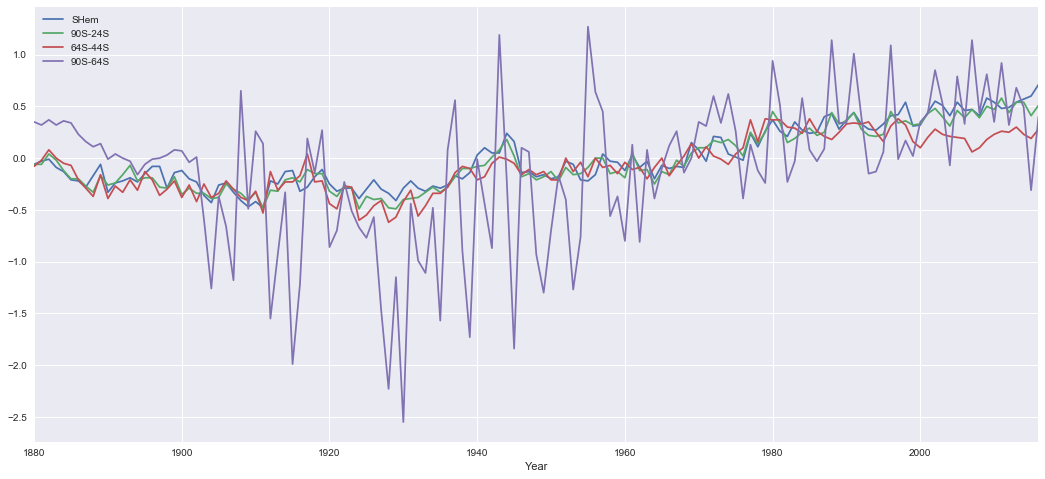

In [15]:
#### zonal yearly means
Tz_years = pd.read_csv('../external/nasa-gistemp/ZonAnn.Ts+dSST.csv', index_col=0)
# could be useful '90S-24S' or '64S-44S'
# '90S-64S' too noisy

cols = [x for x in Tz_years.columns if 'S' in x]
Tz_years[[cols[0],cols[2],cols[5],cols[6]]].plot(figsize = (18,8))

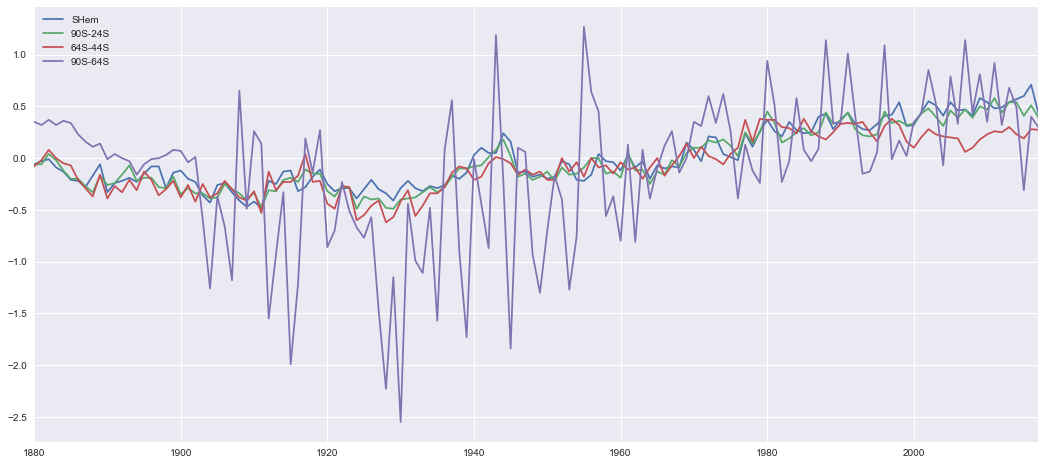

In [47]:
## it includes only until 2016! 
## 2017 has to be forecasted... temporal hack
#Tz_years.ix[2017] = Tz_years.ix[2016]

from sklearn import linear_model

ols = linear_model.LinearRegression()
model = ols.fit(Tz_years.index.values.reshape(-1,1), Tz_years.values)
values_2017 = model.predict(2017)

Tz_years = Tz_years.append(pd.DataFrame(index = [2017], columns = Tz_years.columns, data = values_2017))
Tz_years[[cols[0],cols[2],cols[5],cols[6]]].plot(figsize = (18,8))

In [42]:
values_2017

[array([ 0.51439888]),
 array([ 0.59987978]),
 array([ 0.43080292]),
 array([ 0.70820846]),
 array([ 0.46185058]),
 array([ 0.39265994]),
 array([ 1.32780163]),
 array([ 0.79118935]),
 array([ 0.48165307]),
 array([ 0.43846715]),
 array([ 0.48589953]),
 array([ 0.45649313]),
 array([ 0.27316123]),
 array([ 0.29748068])]

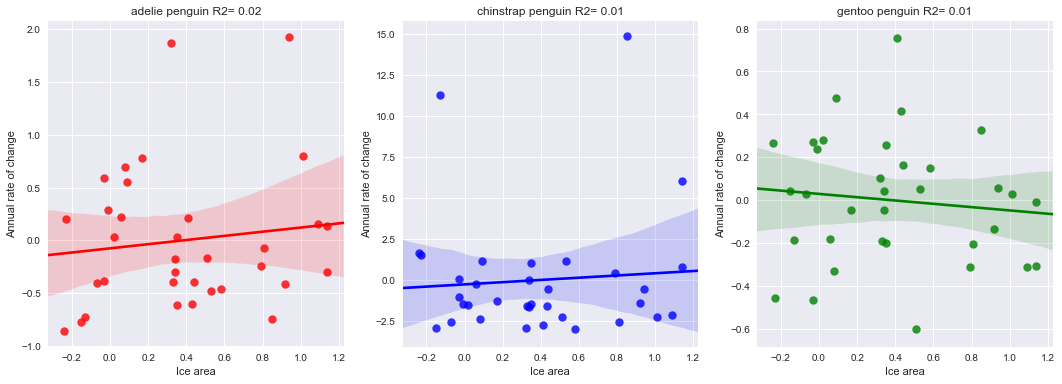

In [118]:
res2 = dict()
models2 = dict()

fig, ax = plt.subplots(ncols =3, figsize=(18,6))
for penguin, axi in zip(names, ax):
    #x = np.log(ice_season.ix[rates.index-1]['extent'].values.astype(np.float64))
    x = Tz_years.ix[rates.index]['90S-64S'].values
    #x = np.log(x)
    y = residues[penguin].values

    X = sm.add_constant(x[(y>-np.inf) & (x>-np.inf)])
    Y = y[(y>-np.inf) & (x>-np.inf)]   
    
    model = sm.OLS(Y,X)
    models2[penguin] = model
    results = model.fit()
    res2[penguin] = results
    prstd, iv_l, iv_u = wls_prediction_std(results)

    sns.regplot(ax = axi,
                x = x, 
                y = y,
                scatter_kws = {'s':70, 'color':colors[penguin]},
                color = colors[penguin] )
    
    axi.set_title('{} R2= {:.2f}'.format(penguin, results.rsquared))
    axi.set_xlabel('Ice area')
    axi.set_ylabel('Annual rate of change')

### adelie
* log '64S-44S', delay -1, R2 = 0.13
* '64S-44S', delay -1, R2 = 0.16

### chinstrap 
* log ice area, delay 0, R2 = 0.16
* ice area, delay 0, R2 = 0.17
* ice extent, delay 0, R2 = 0.09

### gentoo
* log '24S-EQU', delay 0, R2 = 0.12
* log '90S-64S', delay +1, R2 = 0.11
* ice area, delay +1, R2 = 0.11
* ice extent, delay +1, R2 = 0.12



In [61]:
Tz_years

Glob  NHem  SHem  24N-90N  24S-24N  90S-24S  64N-90N  44N-64N  24N-44N  \
Year                                                                           
1880 -0.19 -0.33 -0.06    -0.41    -0.13    -0.06    -1.03    -0.61    -0.21   
1881 -0.11 -0.19 -0.03    -0.30     0.01    -0.06    -0.73    -0.46    -0.13   
1882 -0.09 -0.17 -0.01    -0.23    -0.08     0.04    -1.41    -0.24    -0.02   
1883 -0.19 -0.30 -0.09    -0.36    -0.20    -0.02    -0.37    -0.61    -0.20   
1884 -0.27 -0.42 -0.13    -0.57    -0.16    -0.12    -1.34    -0.61    -0.40   
...    ...   ...   ...      ...      ...      ...      ...      ...      ...   
2013  0.65  0.76  0.54     0.89     0.57     0.54     1.22     1.04     0.69   
2014  0.74  0.91  0.57     1.05     0.66     0.54     1.82     1.13     0.76   
2015  0.86  1.12  0.60     1.25     0.90     0.41     1.64     1.46     1.00   
2016  0.98  1.25  0.71     1.47     0.96     0.51     2.89     1.41     1.06   
2017  0.98  1.25  0.71     1.47     0.96     0.51     2.89     1.41     1.06   

      EQU-24N  24S-EQU  44S-24S  64S-44S  90S-64S  
Year                                               
1880    -0.21    -0.06    -0.02    -0.08     0.35  
1881    -0.01     0.02    -0.06    -0.02     0.32  
1882    -0.07    -0.08     0.03     0.08     0.37  
1883    -0.21    -0.19    -0.01     0.00     0.32  
1884    -0.17    -0.14    -0.14    -0.05     0.36  
...       ...      ...      ...      ...      ...  
2013     0.58     0.56     0.63     0.30     0.68  
2014     0.70     0.62     0.74     0.23     0.49  
2015     0.93     0.88     0.74     0.19    -0.31  
2016     0.92     1.00     0.69     0.28     0.40  
2017     0.92     1.00     0.69     0.28     0.40  

[138 rows x 14 columns]

In [20]:
#with open('results.p', 'wb') as fout:
#    pickle.dump(res, fout)
#
#with open('models.p', 'wb') as fout:
#    pickle.dump(models, fout)    
#

## SANDBOX